This code demonstrates how to load small NORB database into numpy array, it appeared to be non trivial task, because ".mat" files is not a plain text as MNIST ".mat".
Code originated from
https://jessicastringham.net/2018/05/03/smallnorb/
in its turn, it based on
https://github.com/ndrplz/small_norb
I just adopted it for Kaggle.

In [ ]:
#show files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/the-small-norb-dataset-v10/smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
/kaggle/input/the-small-norb-dataset-v10/smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
/kaggle/input/the-small-norb-dataset-v10/smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
/kaggle/input/the-small-norb-dataset-v10/smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
/kaggle/input/the-small-norb-dataset-v10/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
/kaggle/input/the-small-norb-dataset-v10/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
/kaggle/input/checkpoints/model100.0resnet18pretrained.pt
/kaggle/input/checkpoints/finalmobilenet50.pt
/kaggle/input/checkpoints/model99.98mobilenet50.pt


In [ ]:
import os
import cv2
import wandb
import time
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import albumentations as A
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from tqdm.auto import tqdm

In [ ]:
torch.manual_seed(42)


In [ ]:
# https://jessicastringham.net/2018/05/03/smallnorb/
import numpy as np
import struct

DATA_FOLDER = "/kaggle/input/the-small-norb-dataset-v10/"

PREFIXES = {
    'train': 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

FILE_TYPES = ['info', 'cat', 'dat']

# helper function to read int from file
def read_int(f):
    num, = struct.unpack('i', f.read(4))
    return num


# From https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/ 
# "The magic number encodes the element type of the matrix"
# Note: I only copied over the ones I needed for these files.
map_magic_number_to_data_type = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

loaded_data = {}

for dataset, prefix in PREFIXES.items():
    for filetype in FILE_TYPES:
        filename = prefix + filetype + ".mat"
        print('Reading {}'.format(filename))
        
        file_loc = os.path.join(DATA_FOLDER, filename)
        with open( file_loc, 'rb') as f:
            # Read the magic_num, convert it to hexadecimal, and look up the data_type
            raw_magic_num = read_int(f)
            magic_num = format(raw_magic_num, '02x')
            data_type = map_magic_number_to_data_type[magic_num]
            print('dtype', data_type)

            # Read how many dimensions to expect
            ndim = read_int(f)
            
            # Read at least 3 ints, or however many ndim there are
            shape = [
                read_int(f)
                for i in range(max(ndim, 3))
            ]   
            # But in case ndims < 3, take at most n_dim elements
            shape = shape[:ndim]
            print('shape', shape)
    
            # Now load the actual data!
            loaded_data[(dataset, filetype)] = np.fromfile(
                f, 
                dtype=data_type, 
                count=np.prod(shape)
            ).reshape(shape)

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]


In [ ]:
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.6),    
    A.CenterCrop(width=69, height=69), 
    A.Resize(width=96,height=96),
    A.CLAHE(p=0.5),
    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import kornia

from kornia.filters.kernels import (
    get_spatial_gradient_kernel2d, get_spatial_gradient_kernel3d, normalize_kernel2d
)


def spatial_gradient(input: torch.Tensor,
                     mode: str = 'sobel',
                     order: int = 1,
                     normalized: bool = True) -> torch.Tensor:
    r"""Computes the first order image derivative in both x and y using a Sobel
    operator.

    Args:
        input (torch.Tensor): input image tensor with shape :math:`(B, C, H, W)`.
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `sobel`.
        order (int): the order of the derivatives. Default: 1.
        normalized (bool): whether the output is normalized. Default: True.

    Return:
        torch.Tensor: the derivatives of the input feature map. with shape :math:`(B, C, 2, H, W)`.

    Examples:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = spatial_gradient(input)  # 1x3x2x4x4
        >>> output.shape
        torch.Size([1, 3, 2, 4, 4])
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) == 4:
        raise ValueError("Invalid input shape, we expect BxCxHxW. Got: {}"
                         .format(input.shape))
    # allocate kernel
    kernel: torch.Tensor = get_spatial_gradient_kernel2d(mode, order)
    if normalized:
        kernel = normalize_kernel2d(kernel)

    # prepare kernel
    b, c, h, w = input.shape
    tmp_kernel: torch.Tensor = kernel.to(input).detach()
    tmp_kernel = tmp_kernel.unsqueeze(1).unsqueeze(1)

    # convolve input tensor with sobel kernel
    kernel_flip: torch.Tensor = tmp_kernel.flip(-3)

    # Pad with "replicate for spatial dims, but with zeros for channel
    spatial_pad = [
        kernel.size(1) // 2,
        kernel.size(1) // 2,
        kernel.size(2) // 2,
        kernel.size(2) // 2
    ]
    out_channels: int = 3 if order == 2 else 2
    padded_inp: torch.Tensor = F.pad(
        input.reshape(b * c, 1, h, w), spatial_pad, 'replicate')[:, :, None]

    return F.conv3d(padded_inp, kernel_flip, padding=0).view(b, c, out_channels, h, w)



def spatial_gradient3d(input: torch.Tensor,
                       mode: str = 'diff',
                       order: int = 1) -> torch.Tensor:
    r"""Computes the first and second order volume derivative in x, y and d using a diff
    operator.

    Args:
        input (torch.Tensor): input features tensor with shape :math:`(B, C, D, H, W)`.
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `diff`.
        order (int): the order of the derivatives. Default: 1.

    Return:
        torch.Tensor: the spatial gradients of the input feature map.

    Shape:
        - Input: :math:`(B, C, D, H, W)`. D, H, W are spatial dimensions, gradient is calculated w.r.t to them.
        - Output: :math:`(B, C, 3, D, H, W)` or :math:`(B, C, 6, D, H, W)`

    Examples:
        >>> input = torch.rand(1, 4, 2, 4, 4)
        >>> output = spatial_gradient3d(input)
        >>> output.shape
        torch.Size([1, 4, 3, 2, 4, 4])
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) == 5:
        raise ValueError("Invalid input shape, we expect BxCxDxHxW. Got: {}"
                         .format(input.shape))
    # allocate kernel
    kernel: torch.Tensor = get_spatial_gradient_kernel3d(mode, order)

    # prepare kernel
    b, c, d, h, w = input.shape
    tmp_kernel: torch.Tensor = kernel.to(input).detach()
    tmp_kernel = tmp_kernel.repeat(c, 1, 1, 1, 1)

    # convolve input tensor with grad kernel
    kernel_flip: torch.Tensor = tmp_kernel.flip(-3)

    # Pad with "replicate for spatial dims, but with zeros for channel
    spatial_pad = [
        kernel.size(2) // 2,
        kernel.size(2) // 2,
        kernel.size(3) // 2,
        kernel.size(3) // 2,
        kernel.size(4) // 2,
        kernel.size(4) // 2
    ]
    out_ch: int = 6 if order == 2 else 3
    return F.conv3d(F.pad(
        input, spatial_pad, 'replicate'), kernel_flip, padding=0, groups=c).view(b, c, out_ch, d, h, w)



def sobel(input: torch.Tensor, normalized: bool = True, eps: float = 1e-6) -> torch.Tensor:
    r"""Computes the Sobel operator and returns the magnitude per channel.

    Args:
        input (torch.Tensor): the input image with shape :math:`(B,C,H,W)`.
        normalized (bool): if True, L1 norm of the kernel is set to 1.
        eps (float): regularization number to avoid NaN during backprop. Default: 1e-6.

    Return:
        torch.Tensor: the sobel edge gradient magnitudes map with shape :math:`(B,C,H,W)`.

    Example:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = sobel(input)  # 1x3x4x4
        >>> output.shape
        torch.Size([1, 3, 4, 4])
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) == 4:
        raise ValueError("Invalid input shape, we expect BxCxHxW. Got: {}"
                         .format(input.shape))

    # comput the x/y gradients
    edges: torch.Tensor = spatial_gradient(input, normalized=normalized)

    # unpack the edges
    gx: torch.Tensor = edges[:, :, 0]
    gy: torch.Tensor = edges[:, :, 1]

    # compute gradient maginitude
    magnitude: torch.Tensor = torch.sqrt(gx * gx + gy * gy + eps)

    return magnitude



class SpatialGradient(nn.Module):
    r"""Computes the first order image derivative in both x and y using a Sobel
    operator.

    Args:
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `sobel`.
        order (int): the order of the derivatives. Default: 1.
        normalized (bool): whether the output is normalized. Default: True.

    Return:
        torch.Tensor: the sobel edges of the input feature map.

    Shape:
        - Input: :math:`(B, C, H, W)`
        - Output: :math:`(B, C, 2, H, W)`

    Examples:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = SpatialGradient()(input)  # 1x3x2x4x4
    """

    def __init__(self,
                 mode: str = 'sobel',
                 order: int = 1,
                 normalized: bool = True) -> None:
        super(SpatialGradient, self).__init__()
        self.normalized: bool = normalized
        self.order: int = order
        self.mode: str = mode

    def __repr__(self) -> str:
        return self.__class__.__name__ + '('\
            'order=' + str(self.order) + ', ' + \
            'normalized=' + str(self.normalized) + ', ' + \
            'mode=' + self.mode + ')'

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return spatial_gradient(input, self.mode, self.order, self.normalized)



class SpatialGradient3d(nn.Module):
    r"""Computes the first and second order volume derivative in x, y and d using a diff
    operator.

    Args:
        mode (str): derivatives modality, can be: `sobel` or `diff`. Default: `sobel`.
        order (int): the order of the derivatives. Default: 1.

    Return:
        torch.Tensor: the spatial gradients of the input feature map.

    Shape:
        - Input: :math:`(B, C, D, H, W)`. D, H, W are spatial dimensions, gradient is calculated w.r.t to them.
        - Output: :math:`(B, C, 3, D, H, W)` or :math:`(B, C, 6, D, H, W)`

    Examples:
        >>> input = torch.rand(1, 4, 2, 4, 4)
        >>> output = SpatialGradient3d()(input)
        >>> output.shape
        torch.Size([1, 4, 3, 2, 4, 4])
    """

    def __init__(self,
                 mode: str = 'diff',
                 order: int = 1) -> None:
        super(SpatialGradient3d, self).__init__()
        self.order: int = order
        self.mode: str = mode
        self.kernel = get_spatial_gradient_kernel3d(mode, order)
        return

    def __repr__(self) -> str:
        return self.__class__.__name__ + '('\
            'order=' + str(self.order) + ', ' + \
            'mode=' + self.mode + ')'

    def forward(self, input: torch.Tensor) -> torch.Tensor:  # type: ignore
        return spatial_gradient3d(input, self.mode, self.order)



class Sobel(nn.Module):
    r"""Computes the Sobel operator and returns the magnitude per channel.

    Args:
        normalized (bool): if True, L1 norm of the kernel is set to 1.
        eps (float): regularization number to avoid NaN during backprop. Default: 1e-6.

    Return:
        torch.Tensor: the sobel edge gradient magnitudes map.

    Shape:
        - Input: :math:`(B, C, H, W)`
        - Output: :math:`(B, C, H, W)`

    Examples:
        >>> input = torch.rand(1, 3, 4, 4)
        >>> output = Sobel()(input)  # 1x3x4x4
    """

    def __init__(self,
                 normalized: bool = True, eps: float = 1e-6) -> None:
        super(Sobel, self).__init__()
        self.normalized: bool = normalized
        self.eps: float = eps

    def __repr__(self) -> str:
        return self.__class__.__name__ + '('\
            'normalized=' + str(self.normalized) + ')'

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return sobel(input, self.normalized, self.eps)

In [ ]:
class Toys(Dataset):
    
    def __init__(self,data,channels=3,transform=False):
        self.data=data
        self.transform=transform
        self.channels=channels
        
    def __len__(self):
        return len(self.data[('train', 'dat')])
    
    def __getitem__(self,idx):
        if self.channels==1:
            image = self.data[('train','dat')][idx][0]
            
        elif self.channels==2:
            image=self.data[('train','dat')][idx]
            band_3= np.zeros((96,96))
            image = np.dstack((image[0],image[1], band_3))
            image = image.astype('uint8')

        elif self.channels==3:
            image=self.data[('train','dat')][idx]
            band_1 = image[0]
            band_2 = image[1]
            img=torch.tensor(image,dtype=torch.float64)
            band_3  = Sobel()(img.unsqueeze(0))
            band_3 = np.asarray(band_3[0][0])
            image = np.dstack((band_1, band_2, band_3))
            
        image = image.astype('uint8')
        if self.transform is not False:
            dict=self.transform(image=image)
            image=dict['image']
            
        label= self.data[('train','cat')][idx]
        
        image=torch.tensor(image)#,dtype=torch.float64)
        label=torch.tensor(label,dtype=torch.float32)
        info = torch.tensor(loaded_data['train','info'][idx][1:],dtype=torch.float32)
        info[0]=info[0]#*5 + 30.
        info[1] = info[1]#*10.
        info[2]= info[2]#*1.
        if self.channels>1:
            image=image.permute(2,0,1)
        if self.channels==2:
            image=image[:2]
            
        image=image/255
        return image,info,label.long()
        

In [ ]:
dataset=Toys(loaded_data,3,transform)

tensor(0)


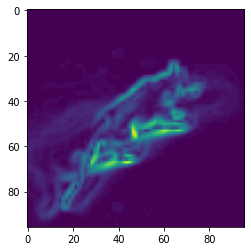

In [ ]:
image,info,label=dataset[0]
plt.imshow(image[2])#.permute(1,2,0))
print(label)

In [ ]:
info

tensor([6., 4., 4.])

In [ ]:
class TestToys(Dataset):
    def __init__(self,data,channels=3):
        self.data=data
        self.channels=channels
        self.transform = A.Compose([A.CenterCrop(width=69, height=69),
                                    A.Resize(96,96),
                                   A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
    def __len__(self):
        return len(self.data[('test', 'dat')])
    
    def __getitem__(self,idx):
        
        if self.channels==1:
            image = self.data[('test','dat')][idx][0]
            
        elif self.channels==2:
            image=self.data[('test','dat')][idx]
            band_3= np.zeros((96,96))
            image = np.dstack((image[0],image[1], band_3))
            image = image.astype('uint8')
            
        elif self.channels==3:
            image=self.data[('test','dat')][idx]
            band_1 = image[0]
            band_2 = image[1]
            img=torch.tensor(image,dtype=torch.float64)
            band_3  = Sobel()(img.unsqueeze(0))
            band_3 = np.asarray(band_3[0][0])
            
            image = np.dstack((band_1, band_2, band_3))
            image = image.astype('uint8')
            
        
        if self.transform is not False:
            dict=self.transform(image=image)
            image=dict['image']
            
        label= self.data[('test','cat')][idx]
        image=torch.tensor(image)
        label=torch.tensor(label,dtype=torch.float32)
        info = torch.tensor(loaded_data['test','info'][idx][1:],dtype=torch.float32)
        info[0]=info[0]#*5 + 30
        info[1] = info[1]#*10
        info[2]= info[2]#*1
        if self.channels>1:
            image=image.permute(2,0,1)
        if self.channels==2:
            image=image[:2]
        image=image/255  
        return image,info,label.long()

In [ ]:
benchmark=TestToys(loaded_data,3)


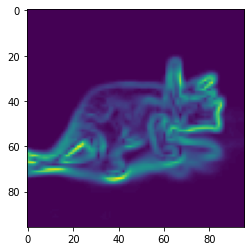

In [ ]:
image,info,label=benchmark[0]
plt.imshow(image[2])#.permute(1,2,0))

In [ ]:
info

tensor([0., 0., 0.])

In [ ]:
train_length=int(0.50*len(dataset))

test_length=len(dataset)-train_length

train_dataset,val_dataset=torch.utils.data.random_split(dataset,(train_length,test_length))
train_length = int(0.75*len(train_dataset))
test_length = len(train_dataset)-train_length
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,(train_length,test_length))
batch_size= 64
trainloader = DataLoader(train_dataset,
        batch_size=batch_size, shuffle=True,num_workers= 2)
valloader = DataLoader(val_dataset,
        batch_size=batch_size, shuffle=True,num_workers=2)
testloader = DataLoader(benchmark,
        batch_size=batch_size, shuffle=False,num_workers=2)

In [ ]:
print(len(train_dataset),len(val_dataset),len(benchmark))

9112 3038 24300


In [ ]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

print(device)

cuda


In [ ]:
import torchvision.models as models
model_ft = models.densenet161(pretrained=True)
model_ft=nn.Sequential(*list(model_ft.children())[:1])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
class MyModel(nn.Module):
    def __init__(self, pretrained_model):
        super(MyModel, self).__init__()
        self.pretrained = pretrained_model
        self.linear = nn.Linear(2211,5)
    def forward(self, x,y):
        x = self.pretrained(x)
        out = F.relu(x, inplace=True)
        out = F.adaptive_max_pool2d(out,output_size=1)
        out = torch.flatten(out, 1)
        out=torch.cat((out,y),1)
        out = self.linear(out)
        return out

model = MyModel(model_ft)

In [ ]:
def find_acc(pred, label):
    
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy

def train(network,criterion, optimizer, trainloader):
    loss_train = 0
    acc_train = 0
    network.train()

    #for step in tqdm(range(len(trainloader))):

    for idx,batch in enumerate(tqdm(trainloader)): 
    
        #images , labels = next(iter(trainloader))
        
        images,info, labels = batch[0],batch[1],batch[2]
        # move the images and labels to GPU
        images     = images.to(device)
        info = info.to(device)
        labels     = labels.to(device)
        
        pred = network(images,info)
      
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(pred , labels)
        
        # find accuracy
        acc_train_step = find_acc(pred, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        #scheduler.step()

        loss_train += loss_train_step.item()
        acc_train += acc_train_step  
            
    loss_train /= len(trainloader)
    acc_train /= len(trainloader)

    return loss_train, acc_train  
        
def validate(network,criterion, testloader): 
    loss_valid = 0
    acc_valid = 0       
    network.eval()  

    #for step in tqdm(range(len(testloader))):
    for idx,batch in enumerate(tqdm(testloader)):
         
        images,info ,labels = batch[0],batch[1],batch[2]
        # move the images and labels to GPU
        images     = images.to(device)
        info = info.to(device)
        labels     = labels.to(device)
        
        pred = network(images,info)
        
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_valid += loss_valid_step.item()
        acc_valid += acc_valid_step

    loss_valid /= len(testloader)
    acc_valid /= len(testloader)

    return loss_valid, acc_valid

def inference(network,criterion, testloader):
    loss_test = 0
    acc_test = 0       
    network.eval()  

    #for step in tqdm(range(len(testloader))):
    for idx,batch in enumerate(tqdm(testloader)):
         
        images,info, labels = batch[0],batch[1],batch[2]
        # move the images and labels to GPU
        images     = images.to(device)
        info = info.to(device)
        labels     = labels.to(device)
        
        pred = network(images,info)
    
        # find the loss and acc for the current step
        loss_valid_step = criterion(pred , labels)
        acc_valid_step = find_acc(pred, labels)
      
        loss_test += loss_valid_step.item()
        acc_test += acc_valid_step

    loss_test /= len(testloader)
    acc_test /= len(testloader)
    return loss_test, acc_test

In [ ]:

wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(name='50_SN1_Densenet161',
           project='50_SN',
           notes='3 Channels with Augs,Sobel', 
           tags=['SGD','StepLR'],
           entity='creganstark')

# WandB Configurations (optional)        
wandb.config.lr = 1e-3
#model=model.float()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr  =  1e-3,
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)

#scheduler = optim.lr_scheduler.CyclicLR(optimizer,base_lr=5e-5,max_lr=5e-4 ,step_size_up=2000)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=9,gamma=0.5)
# Log the network weight histograms (optional)
wandb.watch(model)

num_epochs = 15
start_time = time.time()
prev_acc=0
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(model, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(model, criterion, valloader)
    loss_test, acc_test = inference(model,criterion,testloader)
    scheduler.step()
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f} Test Loss: {:.4f}  Test Acc: {:.4f} '.format(epoch, loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test))

    #Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Test Loss": loss_test,
        "Test Acc": acc_test})
    if acc_test>prev_acc:
      prev_acc=acc_test
      acc_test=str(acc_test)
      paths = "test"+acc_test[:7]+".pt"
      print('Saving Model')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

wandb: Currently logged in as: creganstark (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.1443  Train Acc: 95.3016  Valid Loss: 0.0088  Valid Acc: 99.9023 Test Loss: 0.0871  Test Acc: 97.6936 
Saving Model


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 2  Train Loss: 0.0096  Train Acc: 99.8033  Valid Loss: 0.0043  Valid Acc: 99.9023 Test Loss: 0.0656  Test Acc: 98.0701 
Saving Model


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 3  Train Loss: 0.0051  Train Acc: 99.9563  Valid Loss: 0.0021  Valid Acc: 99.9674 Test Loss: 0.0728  Test Acc: 97.5026 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 4  Train Loss: 0.0032  Train Acc: 99.9672  Valid Loss: 0.0013  Valid Acc: 100.0000 Test Loss: 0.0644  Test Acc: 97.7478 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 5  Train Loss: 0.0027  Train Acc: 99.9672  Valid Loss: 0.0013  Valid Acc: 99.9674 Test Loss: 0.0626  Test Acc: 97.9549 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 6  Train Loss: 0.0028  Train Acc: 99.9563  Valid Loss: 0.0006  Valid Acc: 100.0000 Test Loss: 0.0713  Test Acc: 97.4705 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 7  Train Loss: 0.0017  Train Acc: 99.9599  Valid Loss: 0.0004  Valid Acc: 100.0000 Test Loss: 0.0631  Test Acc: 97.7542 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 8  Train Loss: 0.0028  Train Acc: 99.9563  Valid Loss: 0.0014  Valid Acc: 99.9349 Test Loss: 0.0546  Test Acc: 98.1504 
Saving Model


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 9  Train Loss: 0.0012  Train Acc: 99.9781  Valid Loss: 0.0023  Valid Acc: 99.9349 Test Loss: 0.0743  Test Acc: 97.2914 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 10  Train Loss: 0.0010  Train Acc: 99.9891  Valid Loss: 0.0003  Valid Acc: 100.0000 Test Loss: 0.0636  Test Acc: 97.7295 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 11  Train Loss: 0.0009  Train Acc: 99.9891  Valid Loss: 0.0004  Valid Acc: 100.0000 Test Loss: 0.0627  Test Acc: 97.7190 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 12  Train Loss: 0.0010  Train Acc: 99.9672  Valid Loss: 0.0003  Valid Acc: 100.0000 Test Loss: 0.0685  Test Acc: 97.4622 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 13  Train Loss: 0.0009  Train Acc: 100.0000  Valid Loss: 0.0003  Valid Acc: 100.0000 Test Loss: 0.0652  Test Acc: 97.6002 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 14  Train Loss: 0.0009  Train Acc: 99.9891  Valid Loss: 0.0008  Valid Acc: 99.9674 Test Loss: 0.0806  Test Acc: 97.0327 


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 15  Train Loss: 0.0006  Train Acc: 100.0000  Valid Loss: 0.0004  Valid Acc: 100.0000 Test Loss: 0.0752  Test Acc: 97.1109 
Time Elapsed : 1528.2920s


In [ ]:
testloader = DataLoader(benchmark,
        batch_size=batch_size, shuffle=False,num_workers=2)

In [ ]:
ckpt=torch.load('test98.1504.pt')#LOADING TNE BEST MODEL I GOT IN PREVIOUS 15 epochs
model.load_state_dict(ckpt['model_state_dict'])

In [ ]:
model=model.to(device)

In [ ]:
loss_test, acc_test = inference(model,criterion,testloader)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
loss_test,acc_test

(0.05355461331323328, 98.19789175924502)

In [ ]:
ckpt=torch.load('test98.0700.pt')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [ ]:
loss_test, acc_test = inference(model,criterion,testloader)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
loss_test,acc_test

(0.06365583250819902, 98.2509718913781)

In [ ]:
#TRYING TO FINETUNE FURTHER WITH LOWER LEARNING RATES
wandb.init(name='50_SN1_Densenet161',
           project='50_SN',
           notes='3 Channels with Augs,Sobel', 
           tags=['SGD','StepLR'],
           entity='creganstark')

# WandB Configurations (optional)        
wandb.config.lr = 5e-4
#model=model.float()
#model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr  =  5e-4,
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)

#scheduler = optim.lr_scheduler.CyclicLR(optimizer,base_lr=5e-5,max_lr=5e-4 ,step_size_up=2000)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.5)
# Log the network weight histograms (optional)
#wandb.watch(model)

num_epochs = 10
start_time = time.time()
prev_acc=0
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(model, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(model, criterion, valloader)
    loss_test, acc_test = inference(model,criterion,testloader)
    scheduler.step()
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f} Test Loss: {:.4f}  Test Acc: {:.4f} '.format(epoch, loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test))

    #Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Test Loss": loss_test,
        "Test Acc": acc_test})
    if acc_test>prev_acc:
      prev_acc=acc_test
      acc_test=str(acc_test)
      paths = "test"+acc_test[:7]+".pt"
      print('Saving Model')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

wandb: ERROR Control-C detected -- Run data was not synced


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Problem at: <ipython-input-22-8a76172c7f54> 5 <module>


KeyboardInterrupt: 

In [ ]:
wandb.init(name='50_SN1_Densenet161',
           project='50_SN',
           notes='3 Channels with Augs,Sobel', 
           tags=['SGD','StepLR'],
           entity='creganstark')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr  =  5e-6,
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.5)
num_epochs = 5
start_time = time.time()
prev_acc=0
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(model, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(model, criterion, valloader)
    loss_test, acc_test = inference(model,criterion,testloader)
    scheduler.step()
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f} Test Loss: {:.4f}  Test Acc: {:.4f} '.format(epoch, loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test))

    #Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Test Loss": loss_test,
        "Test Acc": acc_test})
    if acc_test>prev_acc:
      prev_acc=acc_test
      acc_test=str(acc_test)
      paths = "test"+acc_test[:7]+".pt"
      print('Saving Model')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

In [ ]:
wandb.init(name='50_SN1_Densenet161',
           project='50_SN',
           notes='3 Channels with Augs,Sobel', 
           tags=['SGD','StepLR'],
           entity='creganstark')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr  =  5e-7,
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.5)
num_epochs = 3
start_time = time.time()
prev_acc=0
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(model, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(model, criterion, valloader)
    loss_test, acc_test = inference(model,criterion,testloader)
    scheduler.step()
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f} Test Loss: {:.4f}  Test Acc: {:.4f} '.format(epoch, loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test))

    #Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Test Loss": loss_test,
        "Test Acc": acc_test})
    if acc_test>prev_acc:
      prev_acc=acc_test
      acc_test=str(acc_test)
      paths = "test"+acc_test[:7]+".pt"
      print('Saving Model')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

In [ ]:
wandb.init(name='50_SN1_Densenet161',
           project='50_SN',
           notes='3 Channels with Augs,Sobel', 
           tags=['SGD','StepLR'],
           entity='creganstark')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr  =  5e-7,
                      momentum     = 0.9,
                      nesterov     = True,
                      weight_decay = 5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.5)
num_epochs = 3
start_time = time.time()
prev_acc=0
for epoch in range(1, num_epochs+1):
    
    loss_train, acc_train = train(model, criterion, optimizer, trainloader)
    loss_valid, acc_valid = validate(model, criterion, valloader)
    loss_test, acc_test = inference(model,criterion,testloader)
    scheduler.step()
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f} Test Loss: {:.4f}  Test Acc: {:.4f} '.format(epoch, loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test))

    #Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Test Loss": loss_test,
        "Test Acc": acc_test})
    if acc_test>prev_acc:
      prev_acc=acc_test
      acc_test=str(acc_test)
      paths = "test"+acc_test[:7]+".pt"
      print('Saving Model')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))

print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

In [ ]:
ckpt=torch.load('test98.1504.pt')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [ ]:
#os.chdir(r'/kaggle/working')
from IPython.display import FileLink #-> 
FileLink(r'test98.1504.pt')

/kaggle/working/test98.1504.pt

In [ ]:
paths='finalcheckpintsobel1.pth'
torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': loss_valid,
          'val_acc':acc_valid,
          'train_acc':acc_train,
          'loss_acc':loss_train,
          },str(paths))
